# Import Libraries

In [46]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score, GridSearchCV)

from sklearn.preprocessing import (
    scale, LabelEncoder, StandardScaler,
    MinMaxScaler, Normalizer, RobustScaler
)

from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    precision_score, confusion_matrix, recall_score,
    roc_auc_score, roc_curve
)

# to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# The number of numbers that will be shown after the comma.
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 1.&nbsp;Load Dataset

## 1.1 Description

Data Set Story:
- It consists of 10000 observations and 12 variables.
- Independent variables contain information about customers.
- Dependent variable refers to customer abandonment.


Features:
- Surname: Surname
- CreditScore: Credit score
- Geography: Country (Germany / France / Spain)
- Gender: Gender (Female / Male)
- Age: Age
- Tenure: How many years of customer
- Balance: Balance
- NumOfProducts: Bank product used
- HasCrCard: Credit card status (0 = No, 1 = Yes)
- IsActiveMember: Active membership status (0 = No, 1 = Yes)
- EstimatedSalary: Estimated salary
- Exited: Abandoned or not? (0 = No, 1 = Yes)

In [47]:
df = pd.read_csv('churn_modeling_dataset.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [49]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,2886.90,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,1.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,2500.75,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,5000.50,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,7500.25,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


In [50]:
df['CustomerId'].nunique()

10000

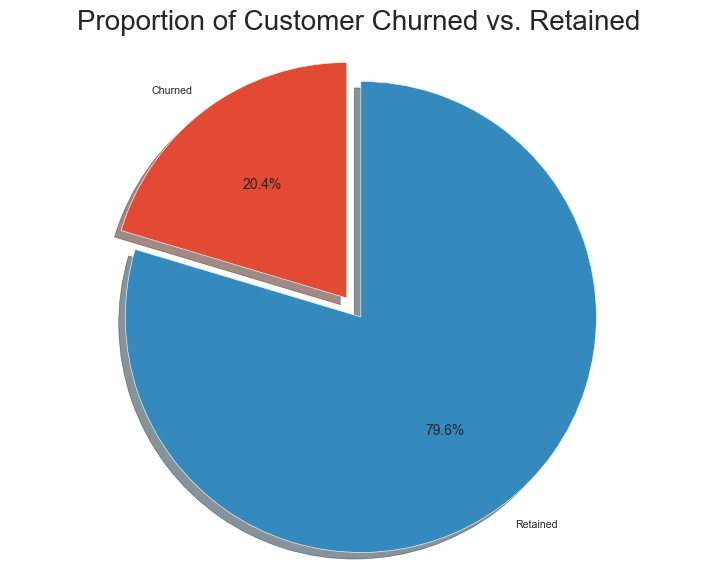

In [51]:
labels = 'Churned', 'Retained'
sizes = [
    df.Exited[df['Exited']==1].count(),
    df.Exited[df['Exited']==0].count()
]

explode = (0, 0.1)
fig, ax = plt.subplots(figsize=(9, 7))
ax.pie(
    sizes, explode=explode,
    labels=labels, autopct='%1.1f%%',
    shadow=True, startangle=90
)
ax.axis('equal')
plt.title("Proportion of Customer Churned vs. Retained", size=20)
plt.show()

# 2.&nbsp;EDA


## 2.1 Data Preparation

In [52]:
dependent_variable_name = "Exited"

In [53]:
def show_unique_count_variables(df):
    nunique_dict = {idx:[val] for idx, val in df.nunique().items()}
    df_nunique = pd.DataFrame(nunique_dict).T
    df_nunique.columns = ["unique_value_count"]
    display(df_nunique)

def data_prepare(df_raw_data):
    df_prep = df_raw_data.copy()

    missing_value_len = df.isnull().any().sum()
    if missing_value_len == 0:
        print("No Missing Value")
    else:
        print("Investigate Missing Value, Missing Value : " + str(missing_value_len))
    print("\n")

    show_unique_count_variables(df=df_prep)

    df_prep['Tenure'] = df_prep.Tenure.astype(float)
    df_prep['NumOfProducts'] = df_prep.NumOfProducts.astype(float)
    return df_prep

### 2.2. Outliers Observe (LOF method and Surpress)


#### 2.2.1. Outlier Editing

In [54]:
def show_outliers(df):
    numerics = [
        'int16', 'int32', 'int64',
        'float16', 'float32', 'float64'
    ]

    df_num_cols = df.select_dtypes(include=numerics)

    sns.set(font_scale=0.7)
    fig, axes = plt.subplots(
        nrows=2, ncols=5,
        gridspec_kw=dict(hspace=0.3),
        figsize=(12, 9)
    )

    fig.tight_layout()
    for ax, col in zip(axes.flatten(), df_num_cols.columns):
        sns.boxplot(
            x=df_num_cols[col], color='green', ax=ax
        )

    fig.suptitle('Observing Outliers', color='r', fontsize=14)

#### Notes




The Local Outlier Factor (LOF) algorithm implemented in scikit-learn calculates the local density deviation of a given data point with respect to its neighbors. The negative_outlier_factor_ attribute in scikit-learn's LOF implementation contains the opposite LOF scores for each data point. Here's how you can interpret it:

1. Local Outlier Factor (LOF):
LOF values close to 1 indicate that the data point is similar in density to its neighbors.
LOF values significantly greater than 1 indicate that the data point is in a region of lower density compared to its neighbors, suggesting it may be an outlier.
The further the LOF value is from 1, the more anomalous the data point is considered.

2. Sign of the LOF:
The negative sign in negative_outlier_factor_ simply denotes that it's the "opposite" LOF, meaning the reciprocal of the LOF values. This is done for mathematical convenience.

3. Interpretation:
Higher negative values indicate higher outlier scores, suggesting stronger evidence of being an outlier.
Lower (less negative) values indicate data points that are less likely to be outliers.

4. Thresholding:
You can set a threshold to identify outliers. Data points with negative_outlier_factor_ below a certain threshold may be considered outliers.

5. Comparing Values:
You can compare the negative_outlier_factor_ values across different data points. Points with significantly lower values compared to others might be more likely to be outliers.

6. Visualization:
Visualizing the negative_outlier_factor_ values against the data points can help identify outliers. Points with exceptionally low (highly negative) values are potential outliers.

#### 2.2.2. Visualization of outliers according to the LOF method

Source:
1. [Link_1](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#:~:text=The%20Local%20Outlier%20Factor%20(LOF,lower%20density%20than%20their%20neighbors.)
2. [Link_2](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor)

In [55]:
def lof_observation(df):

    df_new = df.copy()

    # Select numeric columns
    numerics = [
        'int16', 'int32', 'int64',
        'float16', 'float32', 'float64'
    ]
    df_num_cols = df_new.select_dtypes(include=numerics)

    # Convert selected columns to float64
    df_outlier = df_num_cols.astype("float64")

    # Instantiate LOF model
    clf = LocalOutlierFactor(
        n_neighbors=20, contamination=0.1
    )

    # Fit model and get negative_outlier_factor
    clf.fit(df_outlier)
    np_scores = clf.negative_outlier_factor_
    print("")
    print("Sorted Outliers Score (Lowest 100):")
    print((np.sort(np_scores))[:100])
    print("")

    # Create DataFrame with sorted LOF scores
    scores_df = pd.DataFrame(
        np.sort(np_scores), columns=['LOF_Score']
    )

    # Plot LOF scores
    scores_df.plot(
        stacked=True,
        #xlim=[0, 50], # first 50 observations
        color='r',
        title='Visualization of outliers according to the LOF method',
        style='.-');

    # Determine threshold value
    th_val = -1.6  # Adjust as needed

    # Identify outliers
    outliers = np_scores <= th_val

    # Drop outliers
    df_new = df_new.drop(df_outlier[outliers].index)

    return df_new

#### 2.2.3. Outlier Suppression

In [56]:
def clear_outliers(df):

    # For Age
    Q1 = df["Age"].quantile(0.25)
    Q3 = df["Age"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("Surpress 'Age' if,")
    print("below lower score:", lower)
    print("upper score:", upper)
    print("")
    df.loc[(df["Age"] > upper), "Age"] = upper

    # For Credit Score
    Q1 = df["CreditScore"].quantile(0.25)
    Q3 = df["CreditScore"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("Surpress 'CreditScore' if,")
    print("below lower score:", lower)
    print("upper score:", upper)
    print("")
    df.loc[(df["CreditScore"] < lower), "CreditScore"] = lower
    return df

#### 2.2.4. Outlier Process

In [57]:
def outlier_cleaning_process(df):
    df_clean = lof_observation(df=df)
    df_clean = clear_outliers(df=df_clean)
    return df_clean

### 2.3. Data Analysis
#### 2.3.1. Dependent variable distribution

In [58]:
def show_dependent_variable(df):
    fig, axarr = plt.subplots(2, 3, figsize=(18, 6))
    sns.countplot(x='Geography', hue='Exited', data=df, ax=axarr[0][0])
    sns.countplot(x='Gender', hue='Exited', data=df, ax=axarr[0][1])
    sns.countplot(x='HasCrCard', hue='Exited', data=df, ax=axarr[0][2])
    sns.countplot(x='IsActiveMember', hue='Exited', data=df, ax=axarr[1][0])
    sns.countplot(x='NumOfProducts', hue='Exited', data=df, ax=axarr[1][1])
    sns.countplot(x='Tenure', hue='Exited', data=df, ax=axarr[1][2])
    zero, one = df[dependent_variable_name].value_counts()
    print("Dependent variable distribution;")
    print(dependent_variable_name + " 0 count:", zero)
    print(dependent_variable_name + " 1 count:", one)
    print("")

#### 2.3.2. Numeric columns distribution observation

In [59]:
def show_numeric_columns_distributions(df):
    numerics = [
        'int16', 'int32', 'int64',
        'float16', 'float32', 'float64'
    ]
    df_num_cols = df.select_dtypes(include=numerics)
    columns = df_num_cols.columns[: len(df_num_cols.columns)]
    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot(int(length/2), 3, j+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
        df_num_cols[i].hist(bins=20, edgecolor='black')
        plt.title(i)
    fig = fig.suptitle('Structures of numeric variables', color='r', fontsize=18)
    plt.show()

#### 2.3.3. Status of other variables according to dependent variable

In [60]:
def show_dependent_variable_cross_others_distributions(df):
    numerics = [
        'int16', 'int32', 'int64',
        'float16', 'float32', 'float64'
    ]
    df_dependent_var = df[df[dependent_variable_name]==1]
    df_num_cols = df_dependent_var.select_dtypes(include=numerics)
    columns = df_num_cols.columns[:len(df_num_cols.columns)]

    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot(int(length/2), 3, j+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
        df_num_cols[i].hist(bins=20, edgecolor='black')
        plt.title(i)
    fig = fig.suptitle(
        dependent_variable_name+'Status of other variables according to 1 dependent variable',
        color='r', fontsize=18)
    plt.show()

#### 2.3.4. Categorical variables are observed according to the dependent variable

In [61]:
def show_dependent_variable_cross_categorical_distributions(df, categorical_columns):
    sns.set(font_scale=0.7)
    fig, axes = plt.subplots(
        nrows=int(len(categorical_columns)/2 ),
        ncols=2,
        figsize=(7,9)
    )
    fig.tight_layout()
    for ax,col in zip(axes.flatten(), categorical_columns):
        sns.countplot(
            x=df[col], hue=dependent_variable_name,
            data=df, ax=ax
        )
    fig.suptitle(
        'Categorical variables are monitored according to the dependent variable',
        color='r', fontsize=1
    )

#### 2.3.5. The main method that started all data analysis

In [62]:
def show_data_analysis(df):
    show_dependent_variable(df)
    show_numeric_columns_distributions(df)
    show_dependent_variable_cross_others_distributions(df)
    show_dependent_variable_cross_categorical_distributions(
        df=df_outlier,
        categorical_columns=[
            "Gender", "Geography", "HasCrCard", "IsActiveMember"
        ]
    )

## 3.&nbsp;Feature Engineering

In [63]:
def credit_score_table(row):
    credit_score = row.CreditScore
    if credit_score < 300:
      return "Deep"
    elif 300 <= credit_score < 500:
        return "Very_Poor"
    elif 500 <= credit_score < 601:
        return "Poor"
    elif 601 <= credit_score < 661:
        return "Fair"
    elif 661 <= credit_score < 781:
        return "Good"
    elif 781 <= credit_score < 851:
        return "Excellent"
    else:
        return "Top"

### 3.2. Product utilization RATE by YEAR

In [64]:
def product_utilization_rate_by_year(row):
    number_of_products = row.NumOfProducts
    tenure = row.Tenure

    if number_of_products == 0:
        return 0

    if tenure == 0:
        return number_of_products

    rate = number_of_products/tenure
    return rate

### 3.3. Product utilization RATE by estimated SALARY

In [65]:
def product_utilization_rate_by_estimated_salary(row):
    number_of_products = row.number_of_products
    estimated_salary = row.EstimatedSalary

    if number_of_products == 0:
        return 0

    rate = number_of_products / estimated_salary
    return rate

### 3.4. According to countries monthly average salaries

reference: [Link](https://en.wikipedia.org/wiki/List_of_European_countries_by_average_wage)

In [66]:
def countries_monthly_average_salaries(row):
    fr = 3696
    de = 4740
    sp = 2257
    salary = row.EstimatedSalary / 12
    country = row.Geography # Germany, France and Spain

    if country == 'Germany':
        return salary / de
    elif country == "France":
        return salary / fr
    elif country == "Spain":
        return salary / sp

### 3.5. The main method that started all Feature Engineering

In [67]:
def feature_engineering(df, is_show_graph = False):
    df_fe = df.copy()

    balance_salary_rate = 'balance_salary_rate'
    df_fe[balance_salary_rate] = df_fe.Balance / df_fe.EstimatedSalary

    df_fe = df_fe.assign(
        product_utilization_rate_by_year=df_fe.apply(
            lambda x: product_utilization_rate_by_year(x),
            axis=1
            )
        )

    tenure_rate_by_age = 'tenure_rate_by_age'
    df_fe[tenure_rate_by_age] = df_fe.Tenure/(df_fe.Age - 17)

    credit_score_rate_by_age = 'credit_score_rate_by_age'
    df_fe[credit_score_rate_by_age] = df_fe.CreditScore/(df_fe.Age - 17)

    product_utilization_rate_by_salary = 'product_utilization_rate_by_salary'

    credit_score_rate_by_salary = 'credit_score_rate_by_salary'
    df_fe[credit_score_rate_by_salary] = df_fe.CreditScore/(df_fe.EstimatedSalary)

    if is_show_graph:
        fig, axes = plt.subplots(
            nrows=2, ncols=2, figsize=(20,12))
        fig.tight_layout()
        sns.boxplot(
            y=balance_salary_rate,
            x=dependent_variable_name,
            hue=dependent_variable_name,
            data=df_fe,
            ax=axes[0][0]
        )
        sns.boxplot(
            y=product_utilization_rate_by_year,
            x=dependent_variable_name,
            hue=dependent_variable_name,
            data=df_fe,
            ax=axes[0][1]
        )
        plt.ylim(-1, 5)

    df_fe = df_fe.assign(credit_score_table=df_fe.apply(lambda x: credit_score_table(x), axis=1))
    df_fe = df_fe.assign(countries_monthly_average_salaries = df_fe.apply(lambda x: countries_monthly_average_salaries(x), axis=1))
    return df_fe

# 4.&nbsp;Data Encoding

In [68]:
def data_encoding(df):
    df_model = df.copy()
    # >>>> Categorical columns <<<<<
    non_encoding_columns = [
        "Geography", "HasCrCard","IsActiveMember",
        "Gender", "NumOfProducts", "Tenure", "credit_score_table"]

    df_non_encoding = df_model[non_encoding_columns]
    df_model = df_model.drop(non_encoding_columns, axis=1)
    df_encoding = df_non_encoding.copy()

    encoder = LabelEncoder()
    df_encoding["gender_category"] = encoder.fit_transform(df_non_encoding.Gender)
    df_encoding["country_category"] = encoder.fit_transform(df_non_encoding.Geography)
    df_encoding["credit_score_category"] = encoder.fit_transform(df_non_encoding.credit_score_table)

    df_encoding.reset_index(drop=True, inplace=True)
    df_model.reset_index(drop=True, inplace=True)
    df_model = pd.concat([df_model, df_encoding], axis=1)

    df_model = df_model.drop(
        ["Geography", "Gender" , "CustomerId", "Surname",
         "credit_score_table", "CreditScore", "EstimatedSalary"],
        axis=1)

    df_model = df_model.reset_index()
    df_model = df_model.drop('index', axis=1)

    df_model.loc[df_model.HasCrCard==0, 'credit_card_situation'] = -1
    df_model.loc[df_model.IsActiveMember==0, 'is_active_member'] = -1
    return df_model

In [69]:
df[df.IsActiveMember==0]["Exited"].value_counts()

0    3547
1    1302
Name: Exited, dtype: int64

# 5.&nbsp;Model Preparation

In [70]:
def model_prepare(df_model):

    X = df_model.loc[:, df_model.columns != dependent_variable_name]
    y = df_model[dependent_variable_name]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

### 5.1 Part of Data Train

In [71]:
def data_training(X_train, X_test, y_train, y_test):

    models = []
    models.append(('LOGR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('XGBoost', XGBClassifier()))
    models.append(('LightGBM', LGBMClassifier()))

    res_cols = [
        'model', 'accuracy_score', 'scale_method',
        "0_precision", "0_recall", "1_precision", "1_recall"
    ]
    df_result = pd.DataFrame(columns=res_cols)

    index = 0
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, digits=2, output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']
        res_vals = [
            name, score, "NA",
            zero_report['precision'], zero_report['recall'],
            one_report['precision'], one_report['recall']
        ]
        df_result.at[index, res_cols] = res_vals
        index += 1
    return df_result.sort_values("accuracy_score", ascending=False)

# 6.&nbsp;HELPER Functions

In [72]:
# Function to give best model score and parameters

def best_model(model):
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)

def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method);
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2);
    return (auc_score, fpr_df, tpr_df)

from matplotlib import rc, rcParams
def plot_confusion_matrix(
    cm, classes, normalize=False,
    title='Confusion Matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.rcParams.update({'font.size': 16})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="red" if cm[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 7.&nbsp;Data Cleaning

No Missing Value




,unique_value_count
RowNumber,10000
CustomerId,10000
Surname,2932
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4



Sorted Outliers Score (Lowest 100):
[-2.8575566  -2.67255418 -2.63529713 -2.56530634 -2.48460602 -2.46478139
 -2.4636199  -2.4461954  -2.43548334 -2.38632589 -2.28828598 -2.26554493
 -2.25790134 -2.23198766 -2.19228663 -2.11514597 -2.03776482 -1.86362886
 -1.85073738 -1.78693756 -1.73294653 -1.71837668 -1.69129781 -1.64722045
 -1.62632608 -1.58825693 -1.58358656 -1.58177816 -1.5751525  -1.57156685
 -1.53768607 -1.53096514 -1.52914726 -1.52484598 -1.51779875 -1.51505565
 -1.51189338 -1.51062112 -1.5093727  -1.50411878 -1.48001563 -1.46876021
 -1.45454799 -1.44349038 -1.42916425 -1.42813677 -1.41546026 -1.40826648
 -1.40449841 -1.39335556 -1.38684342 -1.38328634 -1.38173952 -1.37511636
 -1.36703385 -1.35854287 -1.35413109 -1.35311573 -1.35048183 -1.34687987
 -1.34557229 -1.34507715 -1.3431605  -1.33374655 -1.33371372 -1.33135414
 -1.32947134 -1.32941365 -1.32839643 -1.32793551 -1.32752455 -1.32553058
 -1.3241557  -1.32296396 -1.31864692 -1.3178934  -1.31750403 -1.31718478
 -1.31503633 -

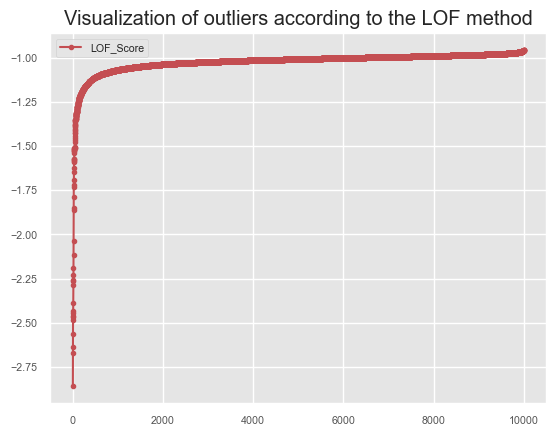

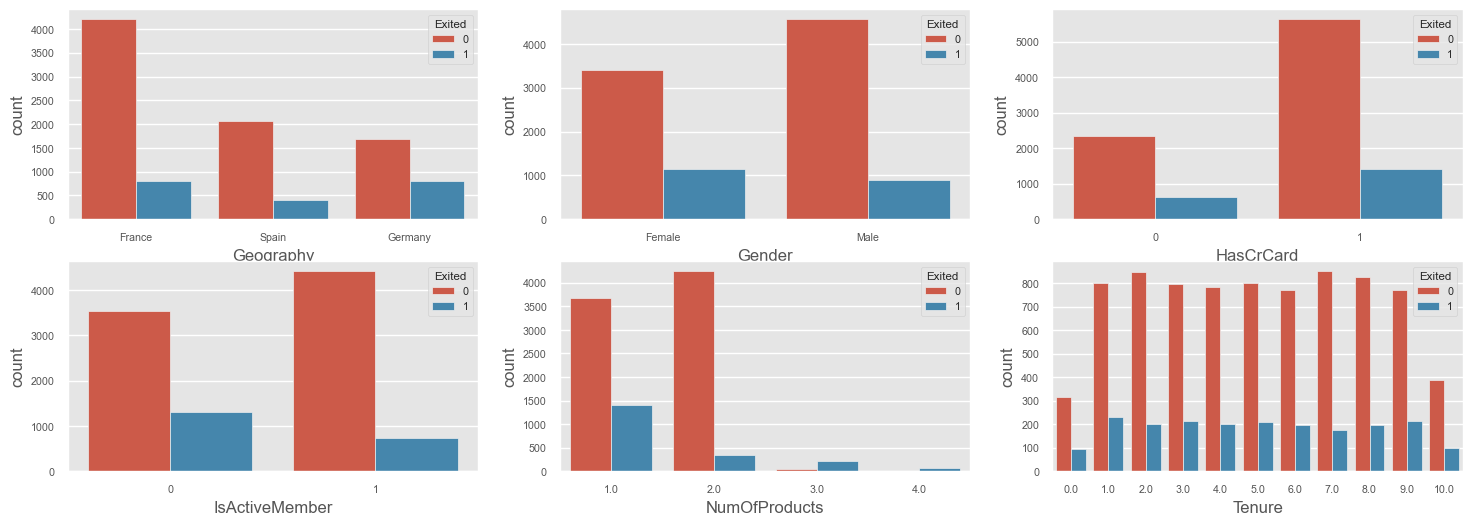

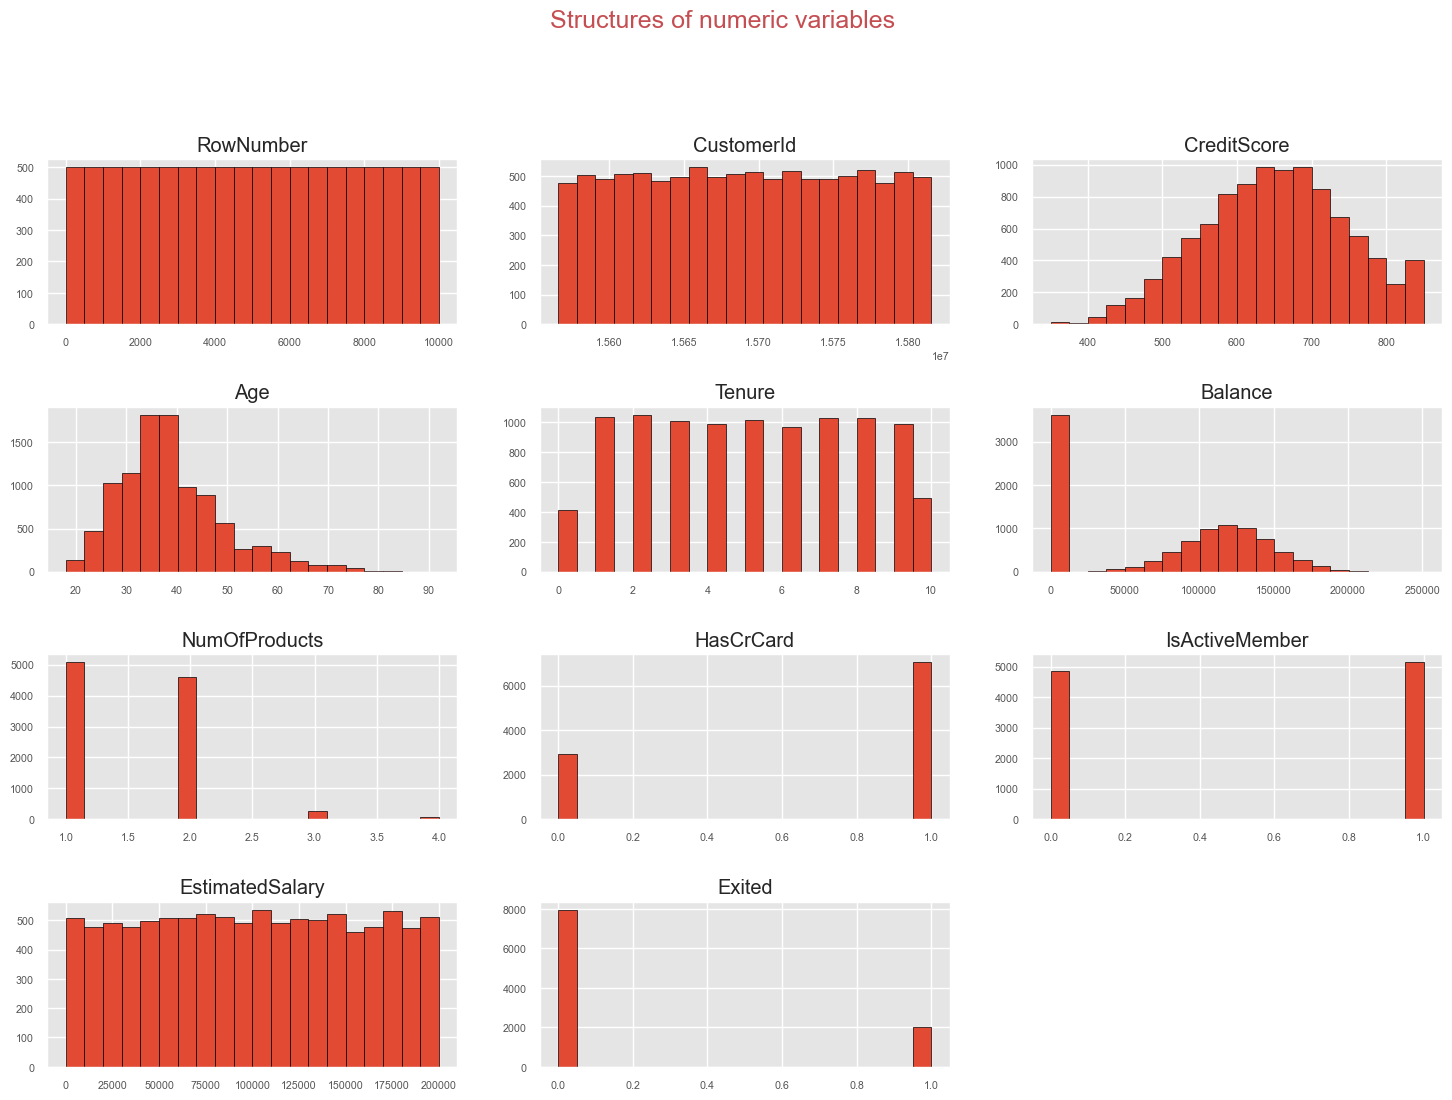

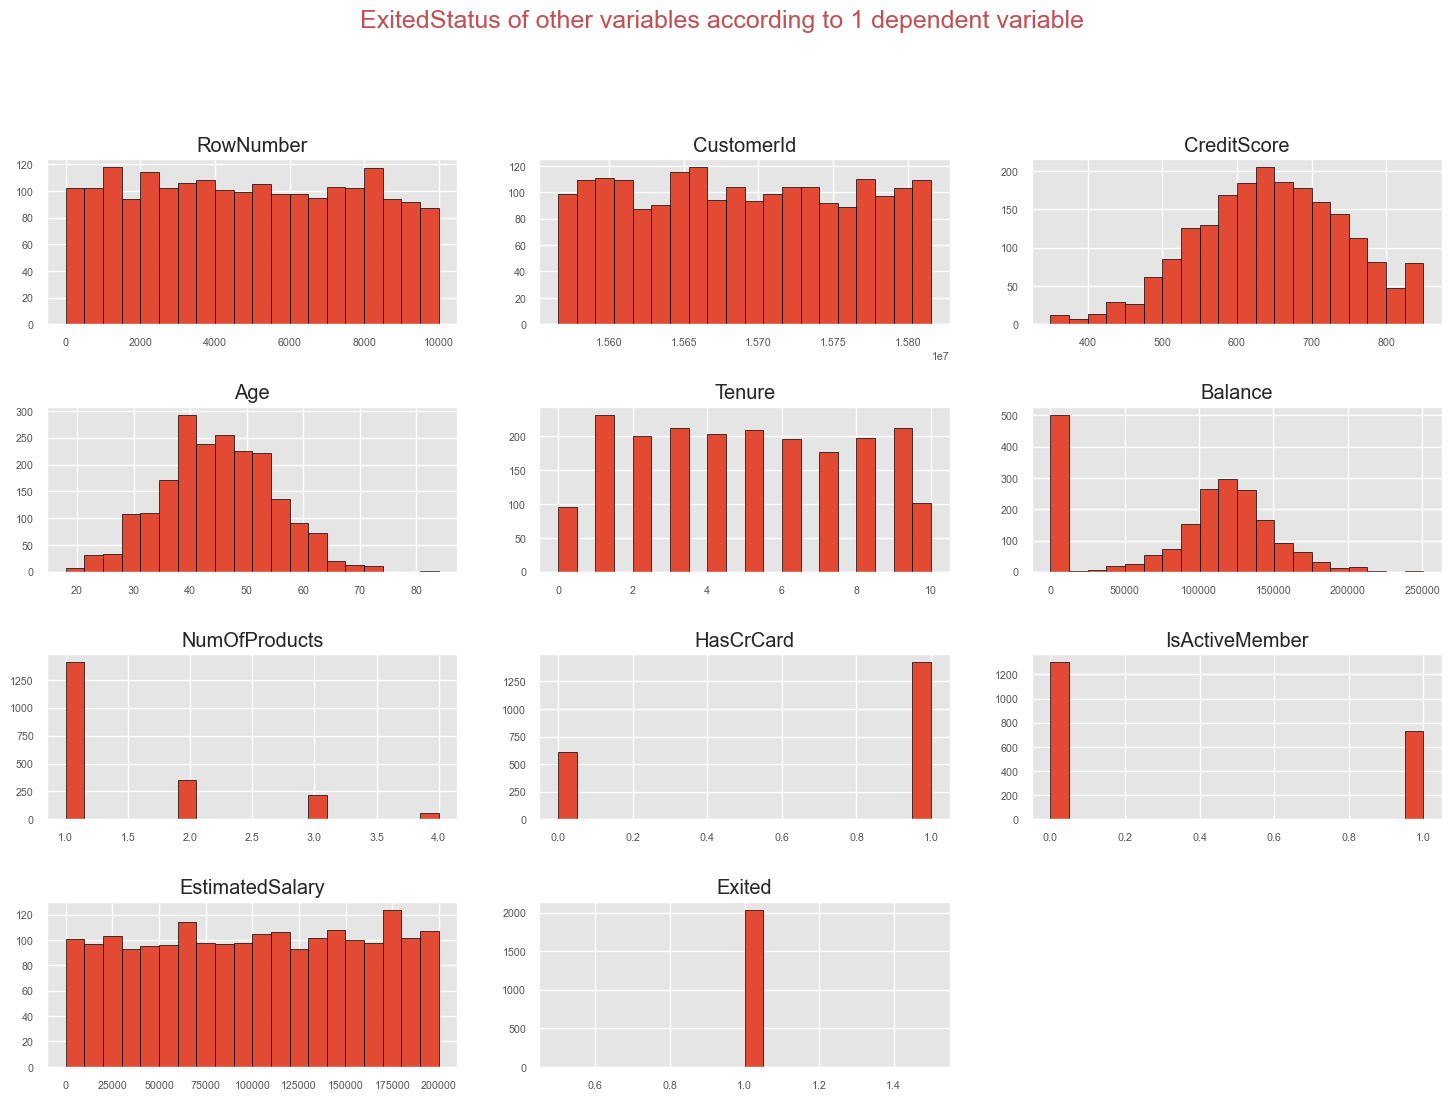

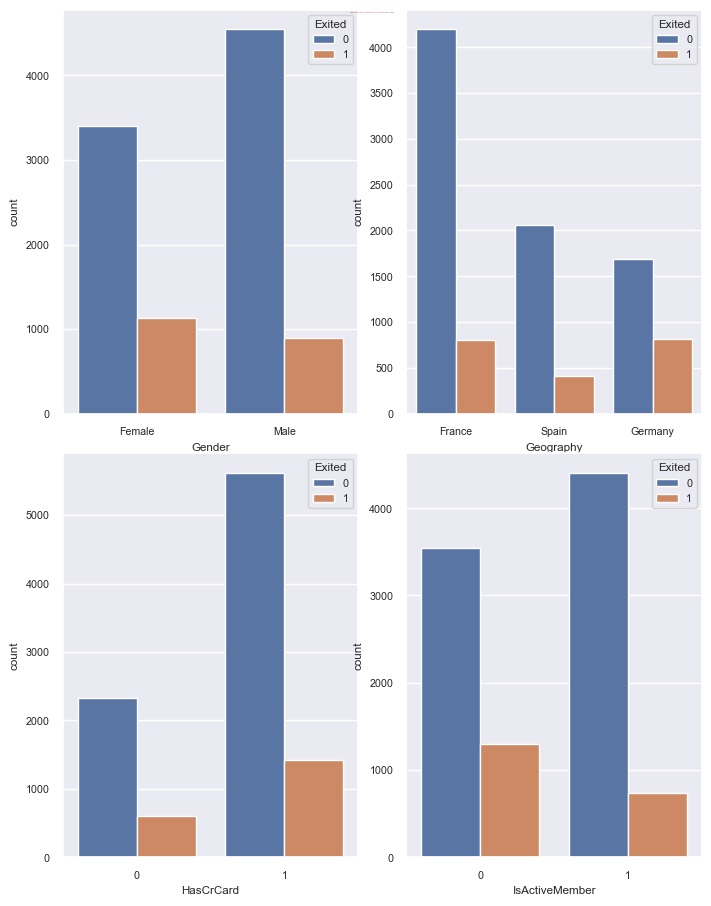

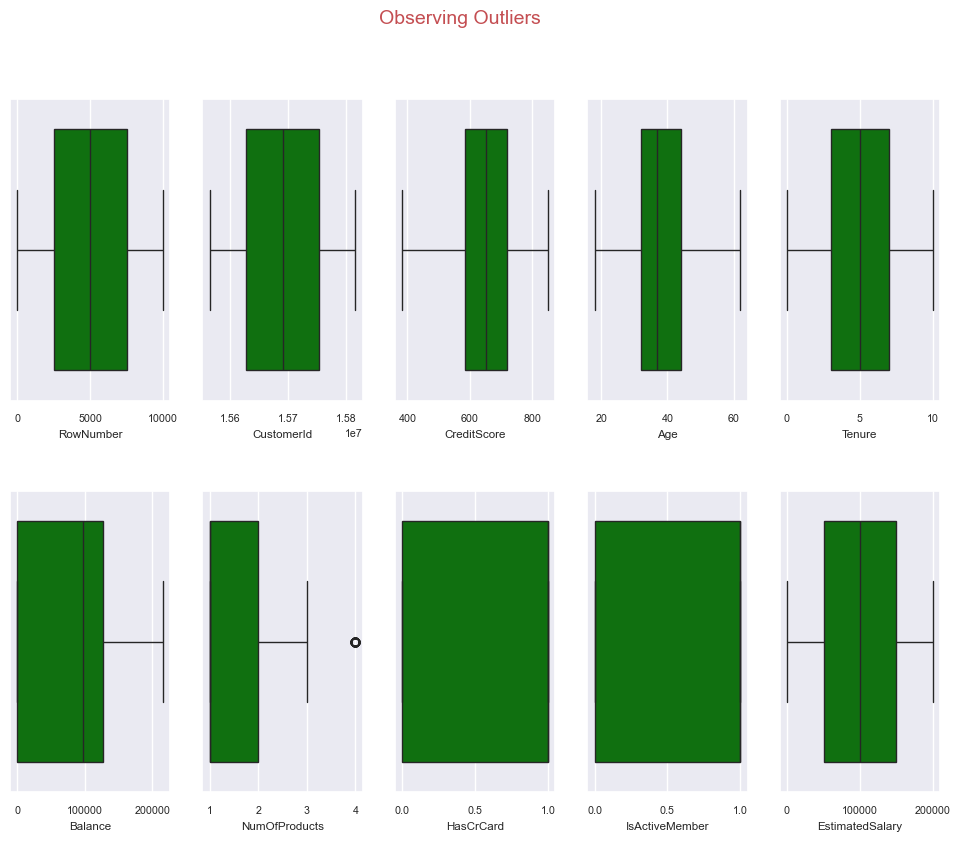

In [73]:
df_prep = data_prepare(df)
df_outlier = outlier_cleaning_process(df=df_prep)

show_data_analysis(df_prep)
show_outliers(df=df_outlier)

Let's see after feature engineering:

In [74]:
df_fe = feature_engineering(df=df_outlier)
df_fe.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,credit_score_table,countries_monthly_average_salaries
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1.00,1,1,101348.88,1,0.00,0.50,0.08,24.76,0.01,Fair,2.29
1,2,15647311,Hill,608,Spain,Female,41,1.00,83807.86,1.00,0,1,112542.58,0,0.74,1.00,0.04,25.33,0.01,Fair,4.16
2,3,15619304,Onio,502,France,Female,42,8.00,159660.80,3.00,1,0,113931.57,1,1.40,0.38,0.32,20.08,0.00,Poor,2.57


And see after data encoding:

In [75]:
df_encoded = data_encoding(df_fe)
df_encoded.drop(
    columns=['credit_card_situation', 'is_active_member'],
    inplace=True
)
df_encoded.head(5)

,RowNumber,Age,Balance,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,countries_monthly_average_salaries,HasCrCard,IsActiveMember,NumOfProducts,Tenure,gender_category,country_category,credit_score_category
0,1,42,0.00,1,0.00,0.50,0.08,24.76,0.01,2.29,1,1,1.00,2.00,0,0,1
1,2,41,83807.86,0,0.74,1.00,0.04,25.33,0.01,4.16,0,1,1.00,1.00,0,2,1
2,3,42,159660.80,1,1.40,0.38,0.32,20.08,0.00,2.57,1,0,3.00,8.00,0,0,3
3,4,39,0.00,0,0.00,2.00,0.05,31.77,0.01,2.12,0,0,2.00,1.00,0,0,2
4,5,43,125510.82,0,1.59,0.50,0.08,32.69,0.01,2.92,1,1,1.00,2.00,0,2,0


Now, let's see correlation graph:

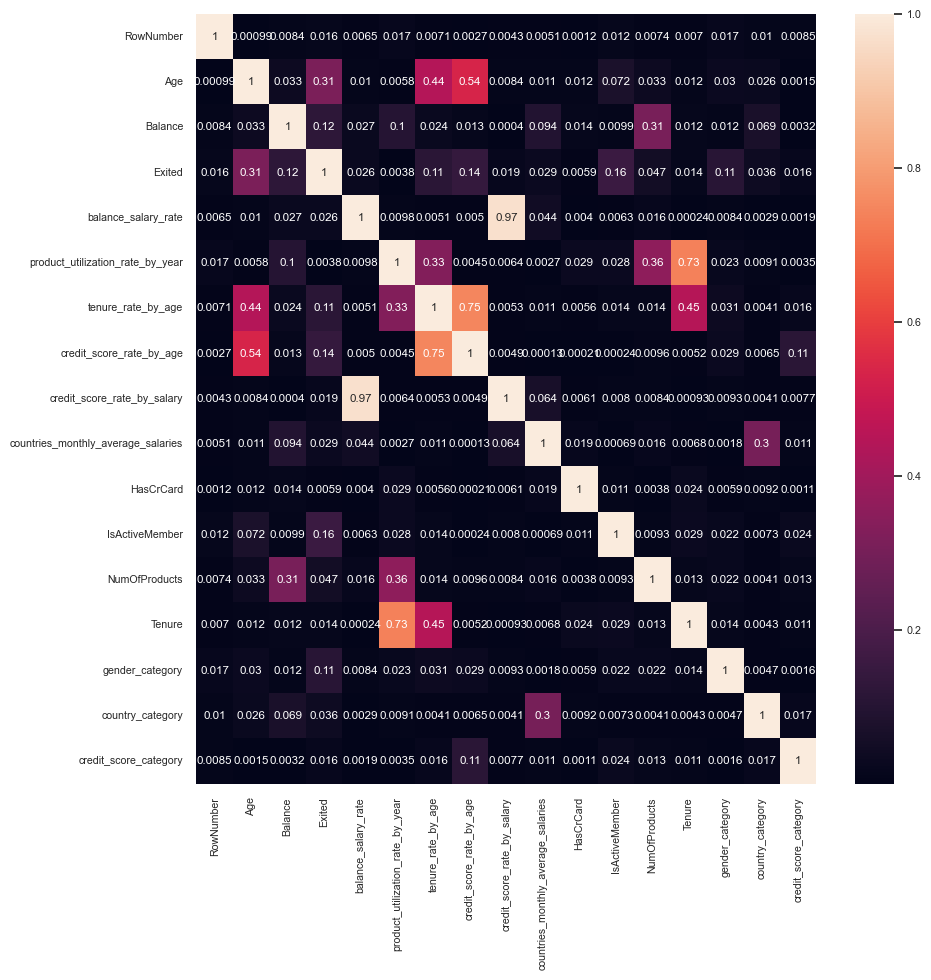

In [76]:
correlation = df_encoded.corr().abs()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True)
plt.show()

List of correlation scores:

In [77]:
corrs_results = df_encoded.corrwith(df_encoded["Exited"]).abs().nlargest(24)
corrs_results

Exited                               1.00
Age                                  0.31
IsActiveMember                       0.16
credit_score_rate_by_age             0.14
Balance                              0.12
tenure_rate_by_age                   0.11
gender_category                      0.11
NumOfProducts                        0.05
country_category                     0.04
countries_monthly_average_salaries   0.03
balance_salary_rate                  0.03
credit_score_rate_by_salary          0.02
credit_score_category                0.02
RowNumber                            0.02
Tenure                               0.01
HasCrCard                            0.01
product_utilization_rate_by_year     0.00
dtype: float64

# 8.&nbsp;Apply Model

In [78]:
# model_prepare test, train split 0.2
X_train, X_test, y_train, y_test = model_prepare(df_model=df_encoded)

### 8.1. Logistic Regression Model

Have a look with Logistic Regression.

In [79]:
logr_model = LogisticRegression()
logr_model.fit(X_train, y_train)
y_pred = logr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score of Logistic Regression: ", accuracy)

              precision    recall  f1-score   support

           0     0.8405    0.9659    0.8989      1615
           1     0.6043    0.2211    0.3237       380

    accuracy                         0.8241      1995
   macro avg     0.7224    0.5935    0.6113      1995
weighted avg     0.7955    0.8241    0.7893      1995

Accuracy score of Logistic Regression:  0.8240601503759398


### 8.2. Model Training

This is for all LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, and LGBMClassifier model objects:

In [80]:
def data_training(X_train, X_test, y_train, y_test):

    models = []
    models.append(('LOGR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('XGBoost', XGBClassifier()))
    models.append(('LightGBM', LGBMClassifier()))

    res_cols = ["model", "accuracy_score", "scale_method", "0_precision", "0_recall", "1_precision", "1_recall"]
    df_result = pd.DataFrame(columns=res_cols)
    index = 0
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, digits=2, output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']

        idx_res_values = [name, score, "NA", zero_report['precision'], zero_report['recall'], one_report['precision'], one_report['recall']]
        # df_result.at[index, res_cols] = idx_res_values
        df_result.loc[index, res_cols] = idx_res_values
        index += 1
    df_result = df_result.sort_values("accuracy_score", ascending=False).reset_index(drop=True)
    return df_result

In [81]:
training_result = data_training(X_train, X_test, y_train, y_test)
training_result

[LightGBM] [Info] Number of positive: 1646, number of negative: 6334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1880
[LightGBM] [Info] Number of data points in the train set: 7980, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206266 -> initscore=-1.347584
[LightGBM] [Info] Start training from score -1.347584


,model,accuracy_score,scale_method,0_precision,0_recall,1_precision,1_recall
0,RF,0.87,NA,0.88,0.96,0.75,0.46
1,LightGBM,0.87,NA,0.89,0.95,0.69,0.53
2,GBM,0.87,NA,0.88,0.96,0.73,0.47
3,XGBoost,0.86,NA,0.89,0.94,0.67,0.53
4,KNN,0.83,NA,0.87,0.94,0.60,0.38
5,LOGR,0.82,NA,0.84,0.97,0.60,0.22
6,CART,0.80,NA,0.88,0.87,0.49,0.51


# 9.&nbsp;Model Tuning

### 9.1. XGBoost Tuning

In [82]:
xgb_model=XGBClassifier(
    learning_rate=0.23,
    max_delta_step=5,
    objective='reg:logistic',
    n_estimators=92,
    max_depth=5,
    eval_metric="logloss",
    gamma=3,
    base_score=0.5
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1615
           1       0.75      0.48      0.59       380

    accuracy                           0.87      1995
   macro avg       0.82      0.72      0.76      1995
weighted avg       0.86      0.87      0.86      1995

Accuracy score of Tuned XGBoost Regression:  0.8716791979949875


### 9.2. Random Forest Tuning

In [83]:
'''
param_grid = {
    'max_depth': [3, 5, 6, 7, 8],
    'max_features': [2, 4, 6, 7, 8, 9],
    'n_estimators' : [50, 100],
    'min_samples_split': [3, 5, 6, 7]
}

randFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, refit = True, verbose = 0)
randFor_grid.fit(X_train, y_train)
best_model(randFor_grid)
'''

# skipped, running too long

"\nparam_grid = {\n    'max_depth': [3, 5, 6, 7, 8],\n    'max_features': [2, 4, 6, 7, 8, 9],\n    'n_estimators' : [50, 100],\n    'min_samples_split': [3, 5, 6, 7]\n}\n\nrandFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, refit = True, verbose = 0)\nrandFor_grid.fit(X_train, y_train)\nbest_model(randFor_grid)\n"

Using the parameters and get final version accuracy score.

In [84]:
rnd_model = RandomForestClassifier(
    max_depth=8,
    max_features=6,
    min_samples_split=6,
    n_estimators=50
)

rnd_model.fit(X_train, y_train)
y_pred = rnd_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of tuned Random Forest model: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1615
           1       0.77      0.43      0.55       380

    accuracy                           0.87      1995
   macro avg       0.83      0.70      0.74      1995
weighted avg       0.86      0.87      0.85      1995

Accuracy score of tuned Random Forest model:  0.8671679197994987


### 9.3. LightGBM Tuning

In [85]:
lgbm_model = LGBMClassifier(
    silent = 0,
    learning_rate = 0.09,
    max_delta_step = 2,
    n_estimators = 100,
    boosting_type = 'gbdt',
    max_depth = 10,
    eval_metric = "logloss",
    gamma = 3,
    base_score = 0.5
)

lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of tuned LightGBM model: ", accuracy_score(y_test, y_pred))

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Info] Number of positive: 1646, number of negative: 6334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1880
[LightGBM] [Info] Number of data points in the train set: 7980, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206266 -> initscore=-1.347584
[LightGBM] [Info] Start training from score -1.347584
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warnin

# 10.&nbsp;Confusion Matrix

Confusion matrix, without normalization
True Negatives:  1533
False Positives:  82
False Negatives:  179
True Positives:  201


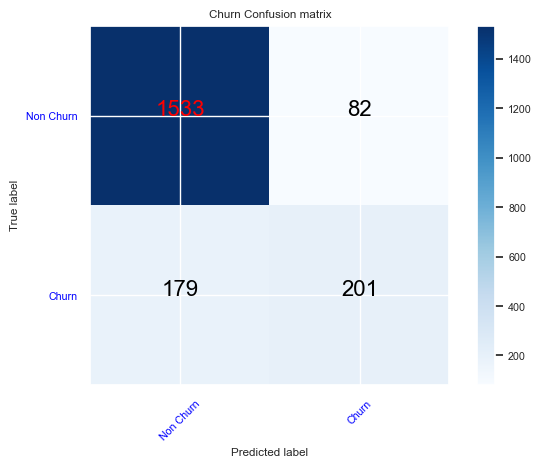

In [86]:
cfm = confusion_matrix(y_test, y_pred=y_pred)
plot_confusion_matrix(
    cfm,
    normalize=False,
    classes=['Non Churn','Churn'],
    title='Churn Confusion matrix'
)

tn, fp, fn, tp = cfm.ravel()

print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

# 11.&nbsp;Feature Importance

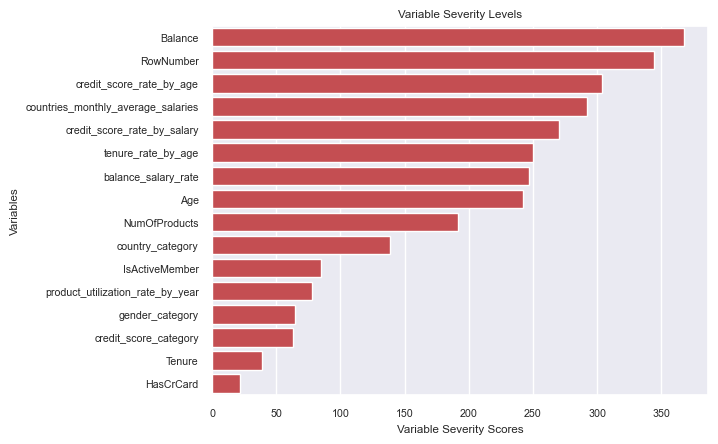

In [87]:
feature_index = df_encoded.loc[:, df_encoded.columns != dependent_variable_name]

feature_importance = pd.Series(
    lgbm_model.feature_importances_,
    index=feature_index.columns
)
feature_importance = feature_importance.sort_values(ascending=False)

sns.barplot(
    x=feature_importance,
    y=feature_importance.index,
    color='r',
    saturation=1
)

plt.xlabel('Variable Severity Scores')
plt.ylabel('Variables')
plt.title('Variable Severity Levels')
plt.show()

# 12.&nbsp;Conclusion



## Storytell setiap bagian 1 – 7
Bagian 1

Dibagian pertama terdapat dataset story tentang churn prediction dimana pada dataset ini terdapat 10.000 baris dan 12 kolom, variabel independennya memuat informasi tentang customer sedangkan variabel dependen nya mengacu pada masalah customer. Di bagian 1 juga di jelaskan fitur – fiturnya : Surname, CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, & Exited.

Bagian 2

Di bagian kedua yaitu data preparation yang pertama kita melakukan observasi outliers menggunakan metode LOF(The Local Outlier Factor). Lalu melakukan visualisasi untuk melihat letak outlier sehingga bisa mendeteksi alasan dari adanya outlier itu. Di bagian kedua tidak hanya membahas observasi outliers tetapi juga melakukan analisis, pada proses analisis ini kita mengkategorikan varibel berdasarkan observasi dari variabel dependent.

bagian 3

Di bagian 3 ada Feature Engineering  isinya berupa penambahan fitur pada tingkat pemanfaatan produk yang di ukur berdasarkan tahun dan estimasi gaji. juga menghitung gaji rata-rata bulanan negara yang ada di jerman, prancis dan spanyol. beberapa fitur baru dihitung menggunakan fungsi tambahan seperti product_utilization_rate_by_year, credit_score_table, dan countries_monthly_average_salaries.

bagian 4

Dibagian 4 kita melakukan encoding pada fitur kategorikal. tujuan dari fungsi ini untuk membuat data lebih mudah dipahami oleh model mesin. dibagian ini juga ada beberapa pembersihan kolom yang tidak relevan/ tidak di perlukan. seperti nama pelanggan & perkiraan gaji.

bagian 5

dibagian 5 ini terdapat model preparation. model preparation ini sangat berguna untuk mempersiapkan data yang nantinya akan digunakan dalam pelatihan model. pada proses ini data dibagi menjadi 2 yaitu data latih(train) & data uji(test). fitur dalam data train & test dinormalisasi menggunakan metode StandarScaler. ibaratnya  Ini seperti membuat semua bahan makanan memiliki skala yang sama sebelum dimasak. fungsi data training ini memberikan ringkasan tentang kinerja relatif dari berbagai model yang telah dilatih, dengan menyediakan metrik evaluasi seperti akurasi, presisi, dan recall untuk setiap model dan kelasnya. Ini dapat membantu dalam pemilihan model terbaik.

bagian 6

dibagian 6 ada helper function yang berfungsi untuk menampilkan skor terbaik(best score), parameter terbaik (best parameters), dan model terbaik (best estimator).Informasi ini berguna untuk mengevaluasi kinerja model dan memilih model terbaik untuk digunakan.

Bagian 7

Data cleaning pada bagian 7 menunjukan visualisasi dari serangkaian proses sebelumnya, dari EDA, Feature engineering, dan data encoding. Di sini juga di tampilkan korelasi antar fitur. Berdasarkan heatmap korelasi yang di buat diketahui bahwa creadit score rate by salary berkorelasi tinggi dengan balance salary rate. Ini artinya semakin tinggi gaji seseorang, semakin mungkin mereka memiliki skor kredit yang baik.



## Model hyperparameter tuning

In [88]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Melakukan oversampling pada data latih
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Definisikan model XGBoost
xgb_model = XGBClassifier(learning_rate=0.23, max_delta_step=5, objective='reg:logistic',
                          n_estimators=92, max_depth=5, eval_metric="logloss", gamma=3, base_score=0.5)

# Melatih model pada data yang telah di-resampling
xgb_model.fit(X_train_resampled, y_train_resampled)

# Melakukan prediksi pada data uji
y_pred = xgb_model.predict(X_test)

# Evaluasi model
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred))


ModuleNotFoundError: No module named 'imblearn'

Confusion matrix, without normalization
True Negatives:  1452
False Positives:  145
False Negatives:  156
True Positives:  241


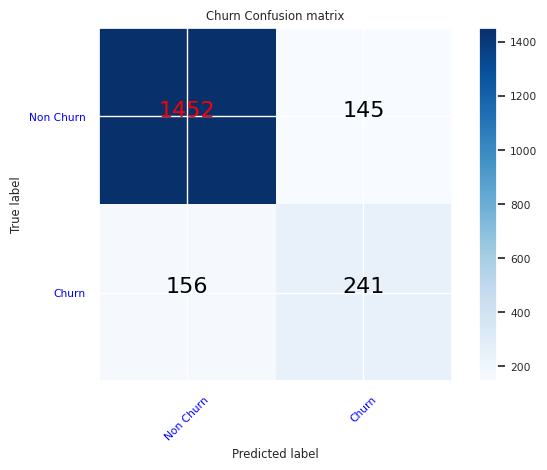

In [ ]:
cfm = confusion_matrix(y_test, y_pred=y_pred)
plot_confusion_matrix(
    cfm,
    normalize=False,
    classes=['Non Churn','Churn'],
    title='Churn Confusion matrix'
)

tn, fp, fn, tp = cfm.ravel()

print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

setelah mencoba beberapa metode pada model XGBoost Regression, metode SMOTE berhasil menurunkan angka fn kurang lebih 22%.

# [Misc.] LOF Visually Explained

In [ ]:
import numpy as np

# Create synthetic dataset
np.random.seed(42)
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]
n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

In [ ]:
dataset = pd.DataFrame(
    data={
        'X1': X[:, 0],
        'X2': X[:, 1],
        'ground_truth': ground_truth
    }
)
dataset

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

In [ ]:
dataset['negative_outlier_factor_'] = X_scores
dataset['prediction'] = y_pred
dataset

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection

def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])

plt.scatter(
    X[:, 0], X[:, 1],
    color="k", s=3.0,
    label="Data points"
)

# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

scatter = plt.scatter(
    X[:, 0], X[:, 1],
    s=1000 * radius, edgecolors="r",
    facecolors="none", label="Outlier scores",
)

plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
plt.legend(
    handler_map={
        scatter: HandlerPathCollection(update_func=update_legend_marker_size)
    }
)
plt.title("Local Outlier Factor (LOF)")
plt.show()

In [ ]:
dataset['radius'] = radius
dataset

$$ reach-dist(p, o) = \max(\text{dist}(p, o), \text{k-distance}(o)) $$

$$ lrd(p) = \frac{1}{\frac{\sum_{o \in N_k(p)}{\text{reach-dist}(p, o)}}{|N_k(p)|}} $$

$$
\text{LOF}(p) = \frac{\sum_{o \in N_k(p)}{\frac{\text{lrd}(o)}{\text{lrd}(p)}}}{|N_k(p)|}
$$


\